# Load

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from scipy import sparse
from scipy.optimize import fsolve,minimize
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [3]:
from scDenorm.denorm import *

In [4]:
from scAnnot.tools import *

In [5]:
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

In [6]:
def solve_bc(p,y1,y2):
    return sum((np.exp(y2*np.log(p[0]))-2*np.exp(y1*np.log(p[0]))+p[1])**2)

In [7]:
from scipy.optimize import curve_fit

def fit_nb(ms):
    
    def nb_func(x, phi):
        return x[0] + (phi * x[0] ** 2)
    
    popt, _ = curve_fit(nb_func, ms['mean'], ms['var'], p0=[1])
    phi = popt[0]
    
    ms['zeros_p'] = np.exp(-ms['mean'])
    ms['zeros_nb'] = (1 + phi * ms['mean']) ** (-1 / phi)
    ms['newVar'] = ms['mean'] + phi * ms['mean'] ** 2
    return ms

In [8]:
def plot_mv(cmean,cvar,ax,title,c='blue',fit=False,save=None):
    ax.loglog()
    ax.scatter(cmean, cvar,s=20,c=c)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    ax.plot(lims, lims, linestyle='--', linewidth=2, alpha=0.75, zorder=0,color='black', label='line')
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Variance')
    ax.set_title(title)
    
    if fit:
        ms=pd.DataFrame({'mean':cmean[0],'var':cvar[0]})
        ms=fit_nb(ms)
        ms=ms.sort_values('mean')
        ax.plot(ms['mean'],ms['newVar'],'k-', alpha=1, zorder=ms.shape[0],color='red', label='line')
    if save:
        plt.savefig(save,dpi=300, bbox_inches='tight',transparent=True)

# Read UCB meta

## Fig 5A,B

In [ ]:
ucb_meta=pd.read_csv('data/ucb_meta.csv',index_col=0)

In [ ]:
ucb_meta=ucb_meta[~ucb_meta.index.isin(['human-fovea-periphery','gbm','cbl-dev'])]

In [ ]:
ucb_meta['base'][ucb_meta['base']=='1']='Without'
ucb_meta['base'][ucb_meta['base']=='e']='Log'
ucb_meta['base'][ucb_meta['base']=='2']='Log2'
ucb_meta['base'][ucb_meta['base'].isna()]='Unknown'

/tmp/ipykernel_17408/1457734253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base'][ucb_meta['base']=='e']='Log'
/tmp/ipykernel_17408/1457734253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base'][ucb_meta['base']=='2']='Log2'
/tmp/ipykernel_17408/1457734253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucb_meta['base'][ucb_meta['base'].isna()]='Unknown'


In [ ]:
tmp=pd.DataFrame(ucb_meta['base'].value_counts())

In [ ]:
tmp['name']=list(tmp.index)

In [ ]:
tmp['name']=pd.Categorical(tmp['name'], categories=['Log', 'Log2', 'Without','Unknown'], ordered=True)

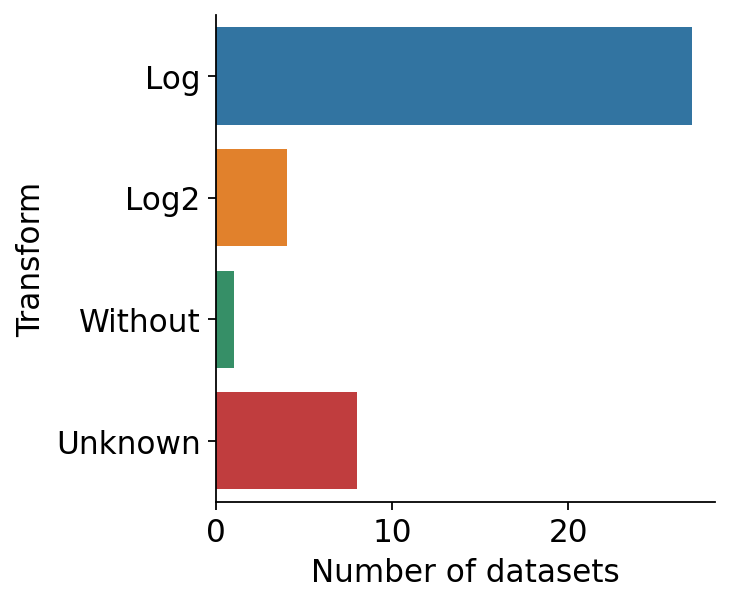

In [ ]:
figsize(4,4)
sns.barplot(y='name',x='base', data=tmp)
sns.despine()
plt.ylabel('Transform')
plt.xlabel('Number of datasets')
plt.savefig('figures/UCB/ucb_meta1.pdf',dpi=300, bbox_inches='tight',transparent=True)

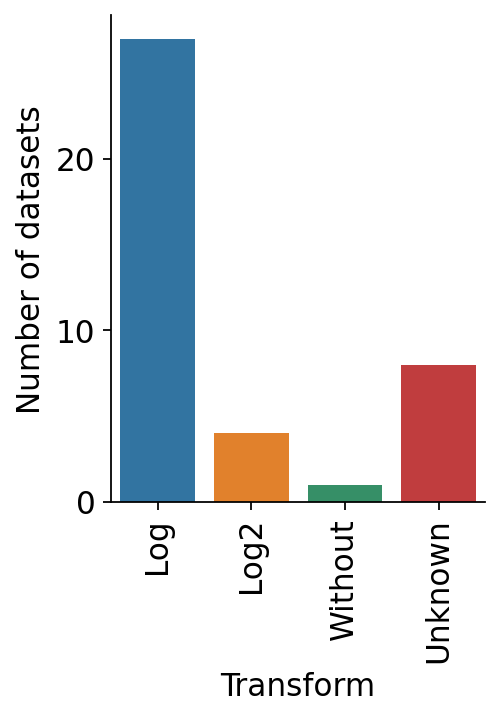

In [ ]:
figsize(3,4)
sns.barplot(x='name',y='base', data=tmp)
sns.despine()
plt.xlabel('Transform')
plt.ylabel('Number of datasets')
plt.xticks(rotation=90)
plt.yticks([0,10,20])
plt.savefig('figures/UCB/ucb_meta1.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
cmap = plt.get_cmap("tab10")

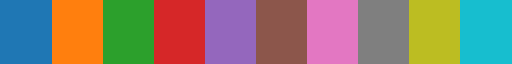

In [ ]:
cmap

In [ ]:
ck={
    'Log':cmap(0),
    'Log2':cmap(1),
    'Without':cmap(2),
    'Unknown':cmap(3)}

In [ ]:
ucb_meta['base'] = pd.Categorical(ucb_meta['base'], categories=['Log', 'Log2', 'Without','Unknown'], ordered=True)

In [ ]:
ucb_meta=ucb_meta.sort_values('base')

In [ ]:
ucb_meta

,name,shortLabel,base,genes,method
adult-testis,adult-testis,Adult Testis,Log,27826,logNorm
covid19-periph-immuno,covid19-periph-immuno,Peripheral Immune in COVID-19 Infection (Wilk ...,Log,26361,logNorm
fetal-lung,fetal-lung,Fetal Lung,Log,23832,logNorm
fetal-liver,fetal-liver,Fetal Liver and Yolk Sac,Log,26349,logNorm
human-epidermis,human-epidermis,Normal and Inflamed Human Epidermis,Log,19791,logNorm
covid19-cytokine-storm,covid19-cytokine-storm,Monocyte-associated Cytokine Storm in Severe C...,Log,18670,logNorm
colorectal-cancer,colorectal-cancer,Colorectal Cancer,Log,33694,logNorm
brain-dronc-seq,brain-dronc-seq,DroNc-seq of Human Brain (Habib et al. 2017.),Log,25587,logNorm
aging-brain,aging-brain,Aging Brain,Log,19746,logNorm
human-cornea,human-cornea,Human Cornea,Log,33538,logNorm


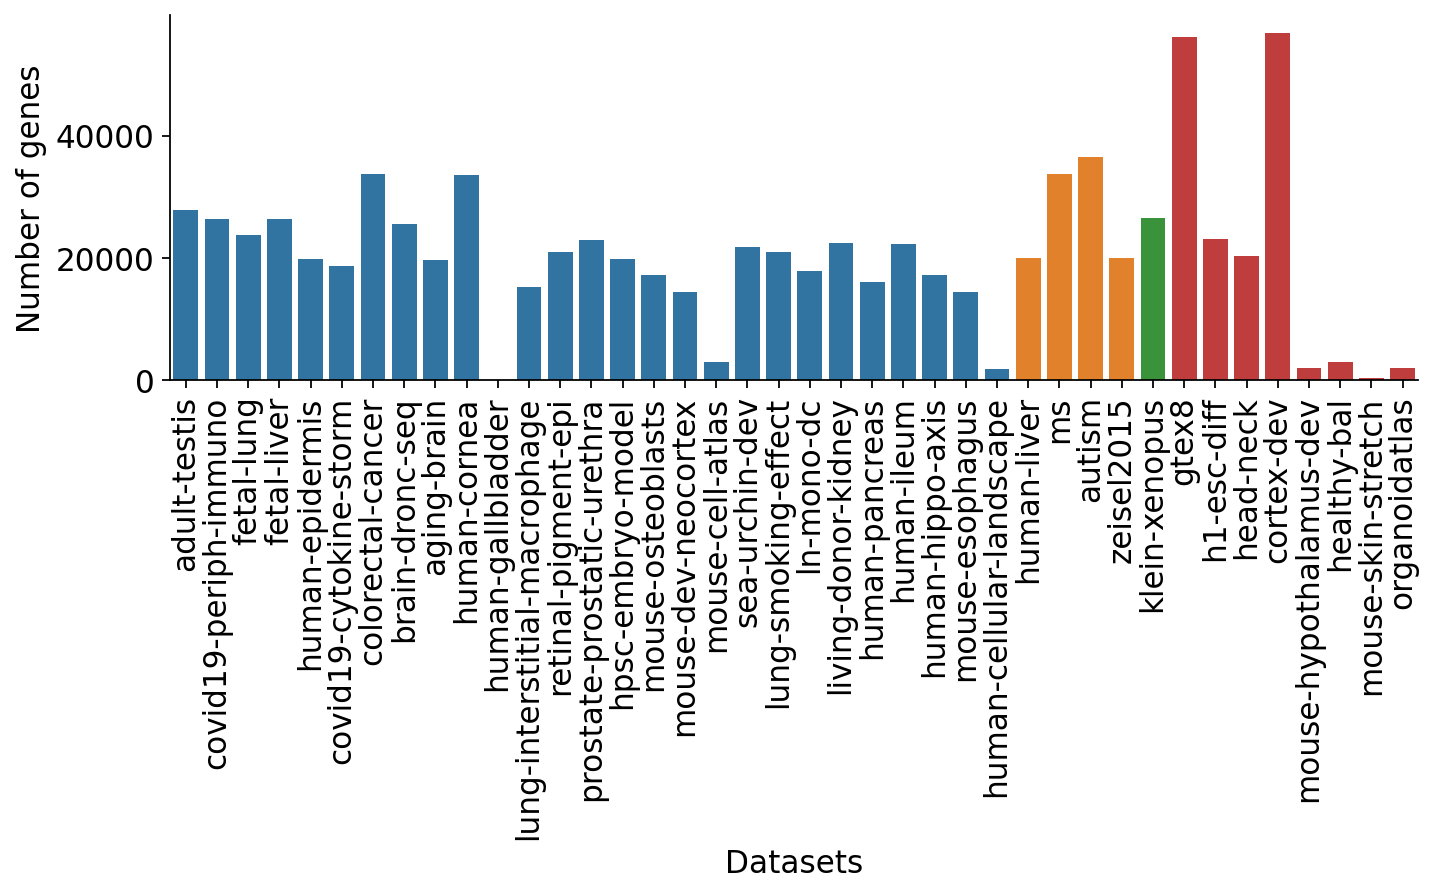

In [ ]:
figsize(10,3)
sns.barplot(x='name', y='genes', data=ucb_meta, palette=[ck[i] for i in ucb_meta['base']])
sns.despine()
plt.grid(visible=False)
plt.xlabel('Datasets')
plt.ylabel('Number of genes')
plt.xticks(rotation=90)
plt.savefig('figures/UCB/ucb_meta1.pdf',dpi=300, bbox_inches='tight',transparent=True)

([<matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>,
  <matplotlib.patches.Wedge>],
 [Text(0.7778174593052024, 0.7778174593052023, 'TPM'),
  Text(-0.7778174593052023, 0.7778174593052024, 'SCTransform'),
  Text(-1.0162674857624157, -0.4209517756015987, 'log2(FPKM+1)'),
  Text(-0.4209517756015994, -1.0162674857624152, 'log2(TPM/10+1)'),
  Text(0.420951775601599, -1.0162674857624154, 'scran'),
  Text(1.0162674857624152, -0.42095177560159946, 'scaled logNorm')])

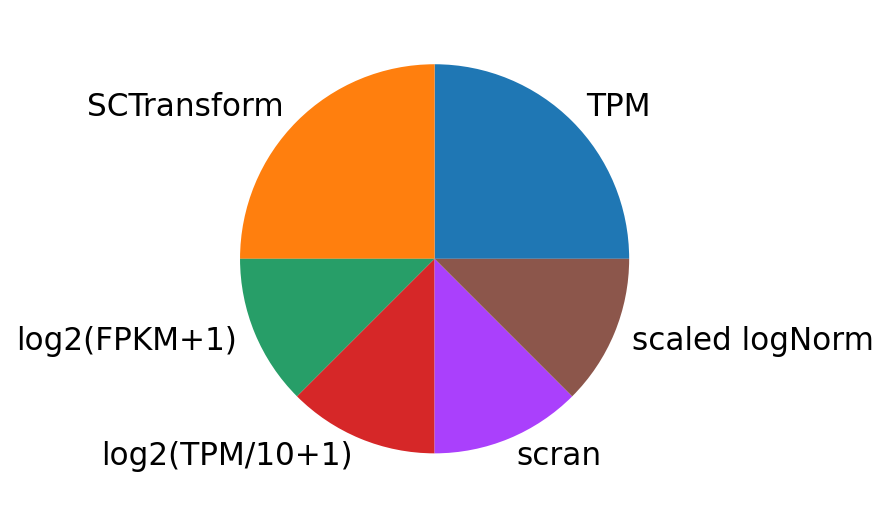

In [ ]:
figsize(4,4)
values = ucb_meta['method'][ucb_meta['base']=='Unknown'].value_counts()
plt.pie(values, labels=values.index)

# Data

In [10]:
with open(f'data/results/ucb_all.pickle', 'rb') as handle:
    ads=pickle.load(handle)

In [11]:
len(ads.keys())

43

In [12]:
h5_names=['adult-testis', 'aging-brain', 'brain-dronc-seq', 'colorectal-cancer', 'covid19-cytokine-storm', 'covid19-periph-immuno','fetal-liver', 'fetal-lung', 'hpsc-embryo-model', 'human-cellular-landscape', 'human-cornea', 'human-epidermis', 'human-gallbladder', 'human-hippo-axis', 'human-ileum', 'human-pancreas',  'living-donor-kidney', 'ln-mono-dc', 'lung-interstitial-macrophage', 'lung-smoking-effect', 'mouse-cell-atlas', 'mouse-dev-neocortex', 'mouse-esophagus', 'mouse-osteoblasts',  'prostate-prostatic-urethra', 'retinal-pigment-epi', 'sea-urchin-dev']

In [13]:
len(h5_names)

27

In [ ]:
total_sum=[]
for i in h5_names:
    print(i)
    smtx1=ads[i].X.copy()
    smtx1.data=np.exp(smtx1.data)-1
    total_sum.append(pd.DataFrame(smtx1.sum(axis=1)))

adult-testis
aging-brain
brain-dronc-seq
colorectal-cancer
covid19-cytokine-storm
covid19-periph-immuno
fetal-liver
fetal-lung
hpsc-embryo-model
human-cellular-landscape
human-cornea
human-epidermis
human-gallbladder
human-hippo-axis
human-ileum
human-pancreas
living-donor-kidney
ln-mono-dc
lung-interstitial-macrophage
lung-smoking-effect
mouse-cell-atlas
mouse-dev-neocortex
mouse-esophagus
mouse-osteoblasts
prostate-prostatic-urethra
retinal-pigment-epi
sea-urchin-dev


In [ ]:
summary_ts=[]
for i,j in enumerate(h5_names):
    summary_ts.append([i+1,j,np.mean(total_sum[i])[0],np.std(total_sum[i])[0]])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
pd.DataFrame(summary_ts)

,0,1,2,3
0,1,adult-testis,10000.000000,0.001288
1,2,aging-brain,10000.000000,0.000806
2,3,brain-dronc-seq,10000.000000,0.002515
3,4,colorectal-cancer,10000.000000,0.000634
4,5,covid19-cytokine-storm,9995.852539,2.675778
5,6,covid19-periph-immuno,1542.547974,93.809105
6,7,fetal-liver,10000.000000,0.000986
7,8,fetal-lung,10000.000000,0.001127
8,9,hpsc-embryo-model,10000.000000,0.000608
9,10,human-cellular-landscape,1115.062988,381.980469


In [ ]:
total_sum=pd.concat(total_sum)

In [ ]:
total_sum.columns=['total']

In [ ]:
total_sum['name']=[x for x in h5_names for i in range(1000)]

In [ ]:
total_sum

,total,name
0,10000.001953,adult-testis
1,9999.999023,adult-testis
2,10000.000000,adult-testis
3,9999.998047,adult-testis
4,9999.998047,adult-testis
...,...,...
995,10000.000000,sea-urchin-dev
996,10000.000977,sea-urchin-dev
997,9999.999023,sea-urchin-dev
998,10000.000977,sea-urchin-dev


## Fig 5.C

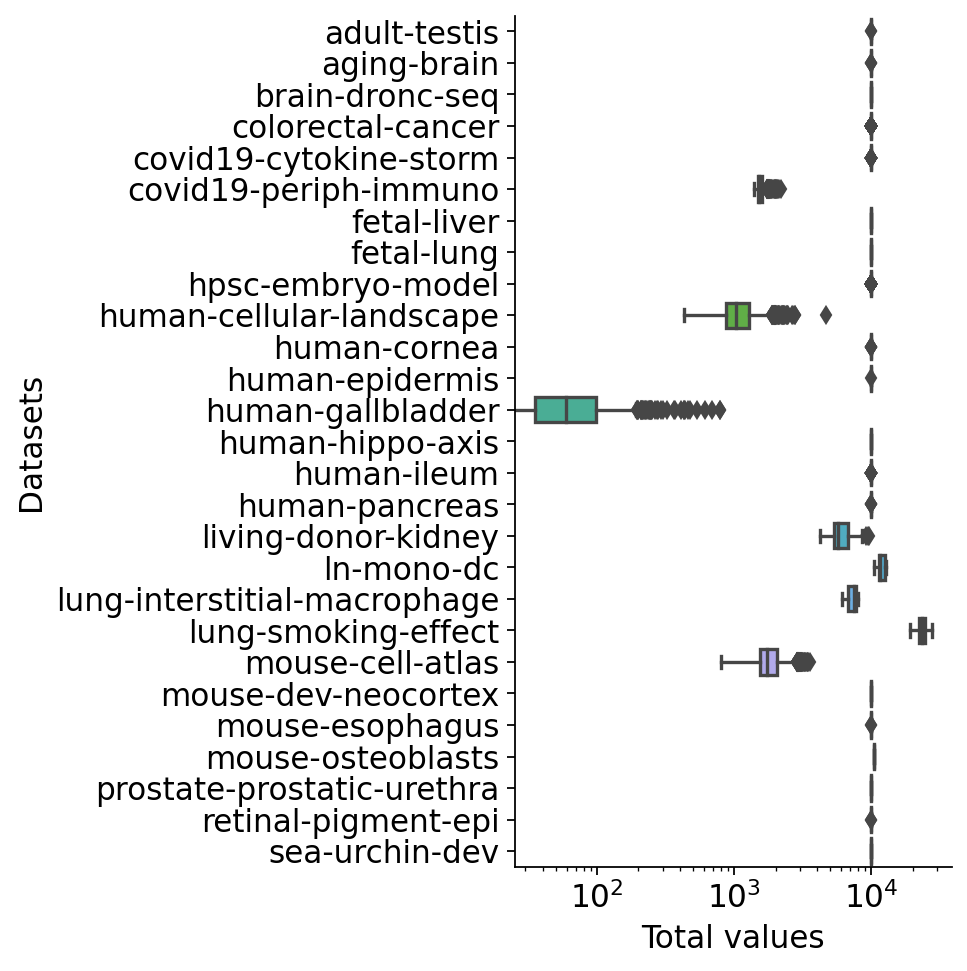

In [ ]:
figsize(3.5,7)
fig,ax=plt.subplots()
sns.boxplot(data=total_sum,y='name',x='total',ax=ax)
ax.set_xscale("log", base=10)
plt.grid(visible=False)
plt.xlabel('Total values')
plt.ylabel('Datasets')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xticks = [1e2, 1e3, 1e4]
xtick_labels = [r'$10^{2}$', r'$10^{3}$', r'$10^{4}$']
plt.xticks(xticks, xtick_labels)
plt.savefig('figures/UCB/scaling_factors_all.pdf',dpi=300, bbox_inches='tight',transparent=True)

# rounding errors

In [14]:
ads_dn=[]
rounding_ers=[]
for i in h5_names:
    print(i)
    ad=ads[i]
    ad1=scdenorm(ad,verbose=1)
    ad1.X.sort_indices()
    
    ad2=scdenorm(ad,verbose=1,rint=False)
    ad2.X.sort_indices()

    tmp2=ad1.X.copy()
    tmp2.data=tmp2.data-ad2.X.data
    rounding_ers.append(tmp2.copy())
    ads_dn.append(ad1.X.copy())

INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


adult-testis
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1681.47it/s]
INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1706.48it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


aging-brain
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1802.23it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1798.41it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


brain-dronc-seq
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1821.04it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1824.30it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


colorectal-cancer
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1663.56it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1660.94it/s]
INFO:root:The dimensions of this data are (1000, 18670).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


covid19-cytokine-storm
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1708.28it/s]
INFO:root:The dimensions of this data are (1000, 18670).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1713.85it/s]
INFO:root:The dimensions of this data are (1000, 26361).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


covid19-periph-immuno
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1831.81it/s]
INFO:root:The dimensions of this data are (1000, 26361).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1831.86it/s]
INFO:root:The dimensions of this data are (1000, 26349).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


fetal-liver
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1706.05it/s]
INFO:root:The dimensions of this data are (1000, 26349).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1722.36it/s]
INFO:root:The dimensions of this data are (1000, 23832).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


fetal-lung
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1730.34it/s]
INFO:root:The dimensions of this data are (1000, 23832).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1755.66it/s]
INFO:root:The dimensions of this data are (1000, 19798).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


hpsc-embryo-model
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1620.94it/s]
INFO:root:The dimensions of this data are (1000, 19798).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1623.81it/s]
INFO:root:The dimensions of this data are (1000, 1772).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-cellular-landscape
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1889.27it/s]
INFO:root:The dimensions of this data are (1000, 1772).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1866.31it/s]
INFO:root:The dimensions of this data are (1000, 33538).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-cornea
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1681.18it/s]
INFO:root:The dimensions of this data are (1000, 33538).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1687.04it/s]
INFO:root:The dimensions of this data are (1000, 19791).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-epidermis
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1753.86it/s]
INFO:root:The dimensions of this data are (1000, 19791).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1744.72it/s]
INFO:root:The dimensions of this data are (1000, 21).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-gallbladder
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1821.52it/s]
INFO:root:The dimensions of this data are (1000, 21).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1805.47it/s]
INFO:root:The dimensions of this data are (1000, 17180).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-hippo-axis
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1810.74it/s]
INFO:root:The dimensions of this data are (1000, 17180).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1843.89it/s]
INFO:root:The dimensions of this data are (1000, 22340).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-ileum
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1826.52it/s]
INFO:root:The dimensions of this data are (1000, 22340).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1831.36it/s]
INFO:root:The dimensions of this data are (1000, 16077).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


human-pancreas
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1766.68it/s]
INFO:root:The dimensions of this data are (1000, 16077).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1769.17it/s]
INFO:root:The dimensions of this data are (1000, 22484).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


living-donor-kidney
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1773.03it/s]
INFO:root:The dimensions of this data are (1000, 22484).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1791.40it/s]
INFO:root:The dimensions of this data are (1000, 17863).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


ln-mono-dc
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1717.44it/s]
INFO:root:The dimensions of this data are (1000, 17863).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1704.28it/s]
INFO:root:The dimensions of this data are (1000, 15171).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


lung-interstitial-macrophage
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1723.87it/s]
INFO:root:The dimensions of this data are (1000, 15171).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1725.10it/s]
INFO:root:The dimensions of this data are (1000, 20952).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


lung-smoking-effect
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1592.64it/s]
INFO:root:The dimensions of this data are (1000, 20952).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1578.65it/s]
INFO:root:The dimensions of this data are (1000, 3005).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-cell-atlas
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1868.67it/s]
INFO:root:The dimensions of this data are (1000, 3005).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1859.16it/s]
INFO:root:The dimensions of this data are (1000, 14498).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-dev-neocortex
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1773.99it/s]
INFO:root:The dimensions of this data are (1000, 14498).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1763.06it/s]
INFO:root:The dimensions of this data are (1000, 14389).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-esophagus
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1835.04it/s]
INFO:root:The dimensions of this data are (1000, 14389).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1843.06it/s]
INFO:root:The dimensions of this data are (1000, 17275).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


mouse-osteoblasts
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1719.89it/s]
INFO:root:The dimensions of this data are (1000, 17275).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1717.90it/s]
INFO:root:The dimensions of this data are (1000, 22875).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


prostate-prostatic-urethra
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1784.73it/s]
INFO:root:The dimensions of this data are (1000, 22875).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1780.60it/s]
INFO:root:The dimensions of this data are (1000, 21040).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


retinal-pigment-epi
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1760.38it/s]
INFO:root:The dimensions of this data are (1000, 21040).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1764.50it/s]
INFO:root:The dimensions of this data are (1000, 21823).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


sea-urchin-dev
b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1644.36it/s]
INFO:root:The dimensions of this data are (1000, 21823).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045


b is 2.718281828459045


100%|██████████| 1000/1000 [00:00<00:00, 1651.79it/s]


In [ ]:
rounding_ers[0].data

array([ 0.0000000e+00, -4.7683716e-07,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  3.8146973e-06], dtype=float32)

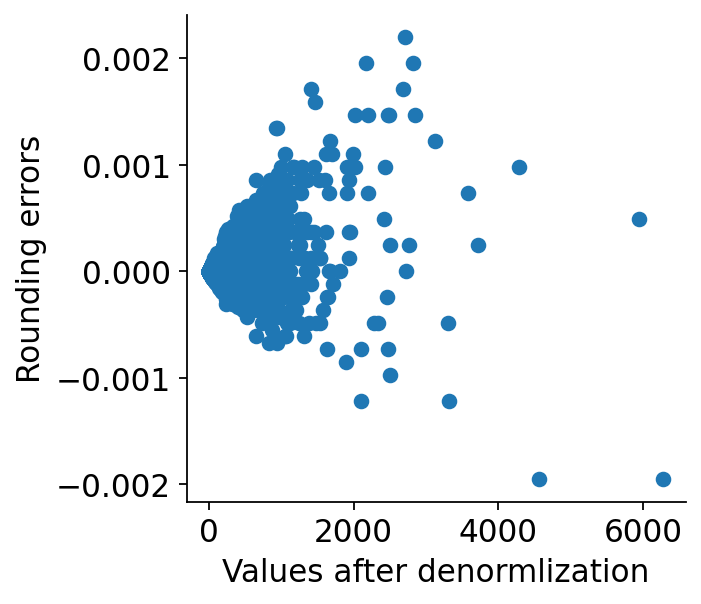

In [ ]:
figsize(4,4)
plt.plot(ads_dn[0].data,rounding_ers[0].data,'o')
plt.grid(visible=False)
plt.xlabel('Values after denormlization')
plt.ylabel('Rounding errors')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/UCB/rounding_errors.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
rounding_ers1=[]
for i,tmp2 in zip(h5_names,rounding_ers):
    tmp2=pd.DataFrame(tmp2.data)
    tmp2.columns=['error']
    tmp2['name']=i
    rounding_ers1.append(tmp2)

In [ ]:
rounding_ers1=pd.concat(rounding_ers1)

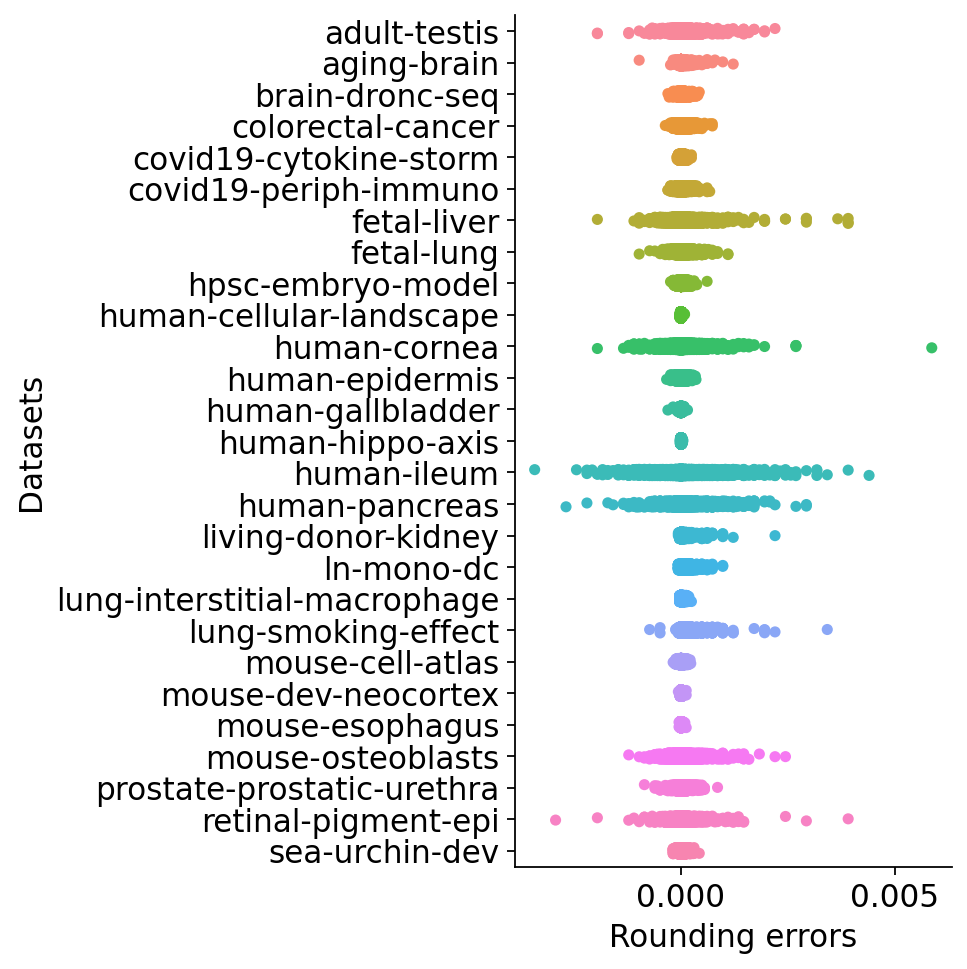

In [ ]:
fig,ax=plt.subplots()
sns.stripplot(data=rounding_ers1[rounding_ers1.name!='human-fovea-periphery'],y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel('Rounding errors')
plt.ylabel('Datasets')
plt.savefig('figures/UCB/rounding_errors3.pdf',dpi=300, bbox_inches='tight',transparent=True)

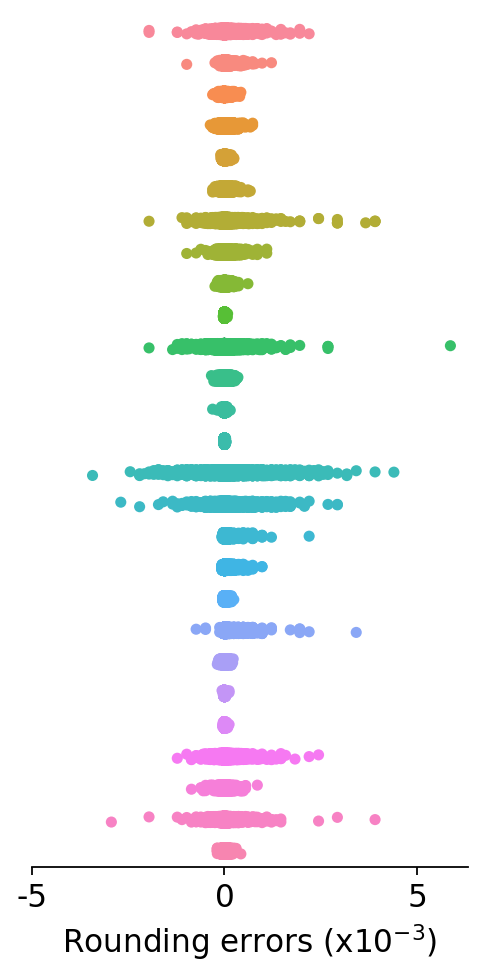

In [ ]:
fig, ax = plt.subplots()
sns.stripplot(data=rounding_ers1[rounding_ers1.name != 'human-fovea-periphery'], y='name', x='error', ax=ax)
sns.despine(left=True)  # Remove left spine
plt.grid(visible=False)
ax.yaxis.set_visible(False)  # Hide y-axis
ax.set_yticklabels([])  # Remove y-tick labels
ax.spines['left'].set_visible(False)
plt.ylabel(' ')
xticks = [-0.005, 0, 0.005]
xtick_labels = ['-5', '0', '5']
plt.xticks(xticks, xtick_labels)
plt.xlabel(r'Rounding errors (x$10^{-3}$)')
plt.show()

## reconstruction errros

In [ ]:
h5_names1=['adult-testis', 'aging-brain', 'brain-dronc-seq', 'colorectal-cancer', 'fetal-liver', 'fetal-lung', 'hpsc-embryo-model',  'human-cornea', 'human-epidermis',  'human-hippo-axis', 'human-ileum', 'human-pancreas',  'mouse-dev-neocortex', 'mouse-esophagus', 'prostate-prostatic-urethra', 'retinal-pigment-epi', 'sea-urchin-dev']

In [ ]:
recon_ers=[]
for i in h5_names1:
    ad=ads[i]
    ad.X.sort_indices()
    
    ad3=scdenorm(ad,verbose=1,cutoff=0.5)
    sc.pp.normalize_total(ad3, target_sum=10000)
    sc.pp.log1p(ad3)
    ad3.X.sort_indices()
    tmp2=ad.X.copy()
    tmp2.data=tmp2.data-ad3.X.data
    recon_ers.append(tmp2.copy())

INFO:root:The dimensions of this data are (1000, 27826).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1698.31it/s]
INFO:root:The dimensions of this data are (1000, 19746).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1764.65it/s]
INFO:root:The dimensions of this data are (1000, 25587).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1819.85it/s]
INFO:root:The dimensions of this data are (1000, 33694).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1655.05it/s]
INFO:root:The dimensions of this data are (1000, 26349).
INFO:root:select base
INFO:root:denormlizing ...the base is 2.718281828459045
100%|██████████| 1000/1000 [00:00<00:00, 1683.75it/s]
INFO:root:The dimensions of this data are (1000, 23832)

In [ ]:
recon_ers1=[]
for i,tmp2 in zip(h5_names1,recon_ers):
    tmp2=pd.DataFrame(tmp2.data)
    tmp2.columns=['error']
    tmp2['name']=i
    recon_ers1.append(tmp2)

In [ ]:
recon_ers1=pd.concat(recon_ers1)

In [ ]:
recon_ers1

,error,name
0,-5.960464e-08,adult-testis
1,0.000000e+00,adult-testis
2,-5.960464e-08,adult-testis
3,-5.960464e-08,adult-testis
4,-5.960464e-08,adult-testis
...,...,...
3841527,-1.490116e-08,sea-urchin-dev
3841528,-1.490116e-08,sea-urchin-dev
3841529,-1.490116e-08,sea-urchin-dev
3841530,-1.490116e-08,sea-urchin-dev


In [ ]:
recon_ers2=pd.concat([recon_ers1,pd.DataFrame({'error':[None]*len(h5_names),'name':h5_names})])

In [ ]:
recon_ers2=recon_ers2.sort_values('name')

In [ ]:
recon_ers2['error']=recon_ers2['error']*1e6

In [ ]:
recon_ers2

,error,name
0,-0.059605,adult-testis
1718027,0.000000,adult-testis
1718028,0.238419,adult-testis
1718029,0.000000,adult-testis
1718030,0.000000,adult-testis
...,...,...
1280523,0.000000,sea-urchin-dev
1280524,0.000000,sea-urchin-dev
1280525,0.000000,sea-urchin-dev
1280513,0.000000,sea-urchin-dev


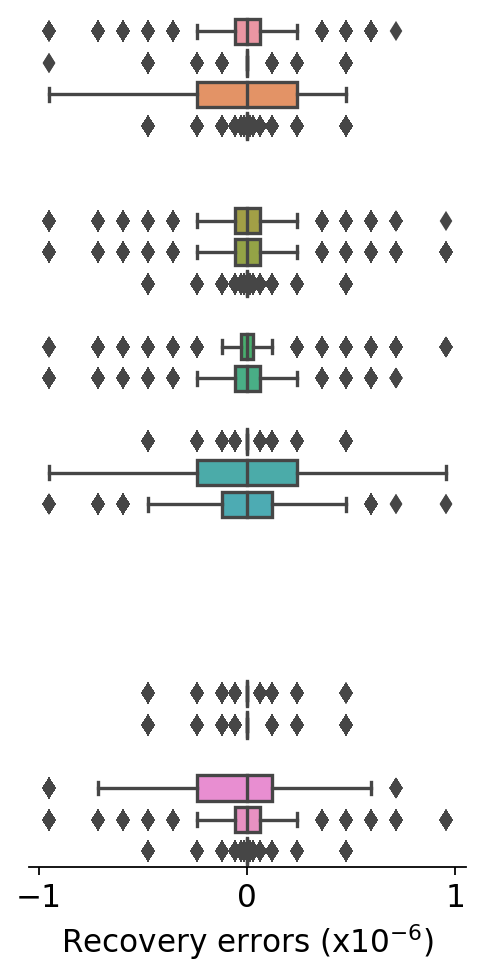

In [ ]:
fig,ax=plt.subplots()
sns.boxplot(data=recon_ers2,y='name',x='error',ax=ax)
sns.despine()
plt.grid(visible=False)
plt.xlabel(r'Recovery errors (x$10^{-6}$)')
ax.yaxis.set_visible(False)  # Hide y-axis
ax.set_yticklabels([])  # Remove y-tick labels
ax.spines['left'].set_visible(False)
plt.ylabel(' ')
plt.savefig('figures/UCB/recon_errors2.pdf',dpi=300, bbox_inches='tight',transparent=True)

# plot rounding errors

In [ ]:
len(rounding_ers)

27

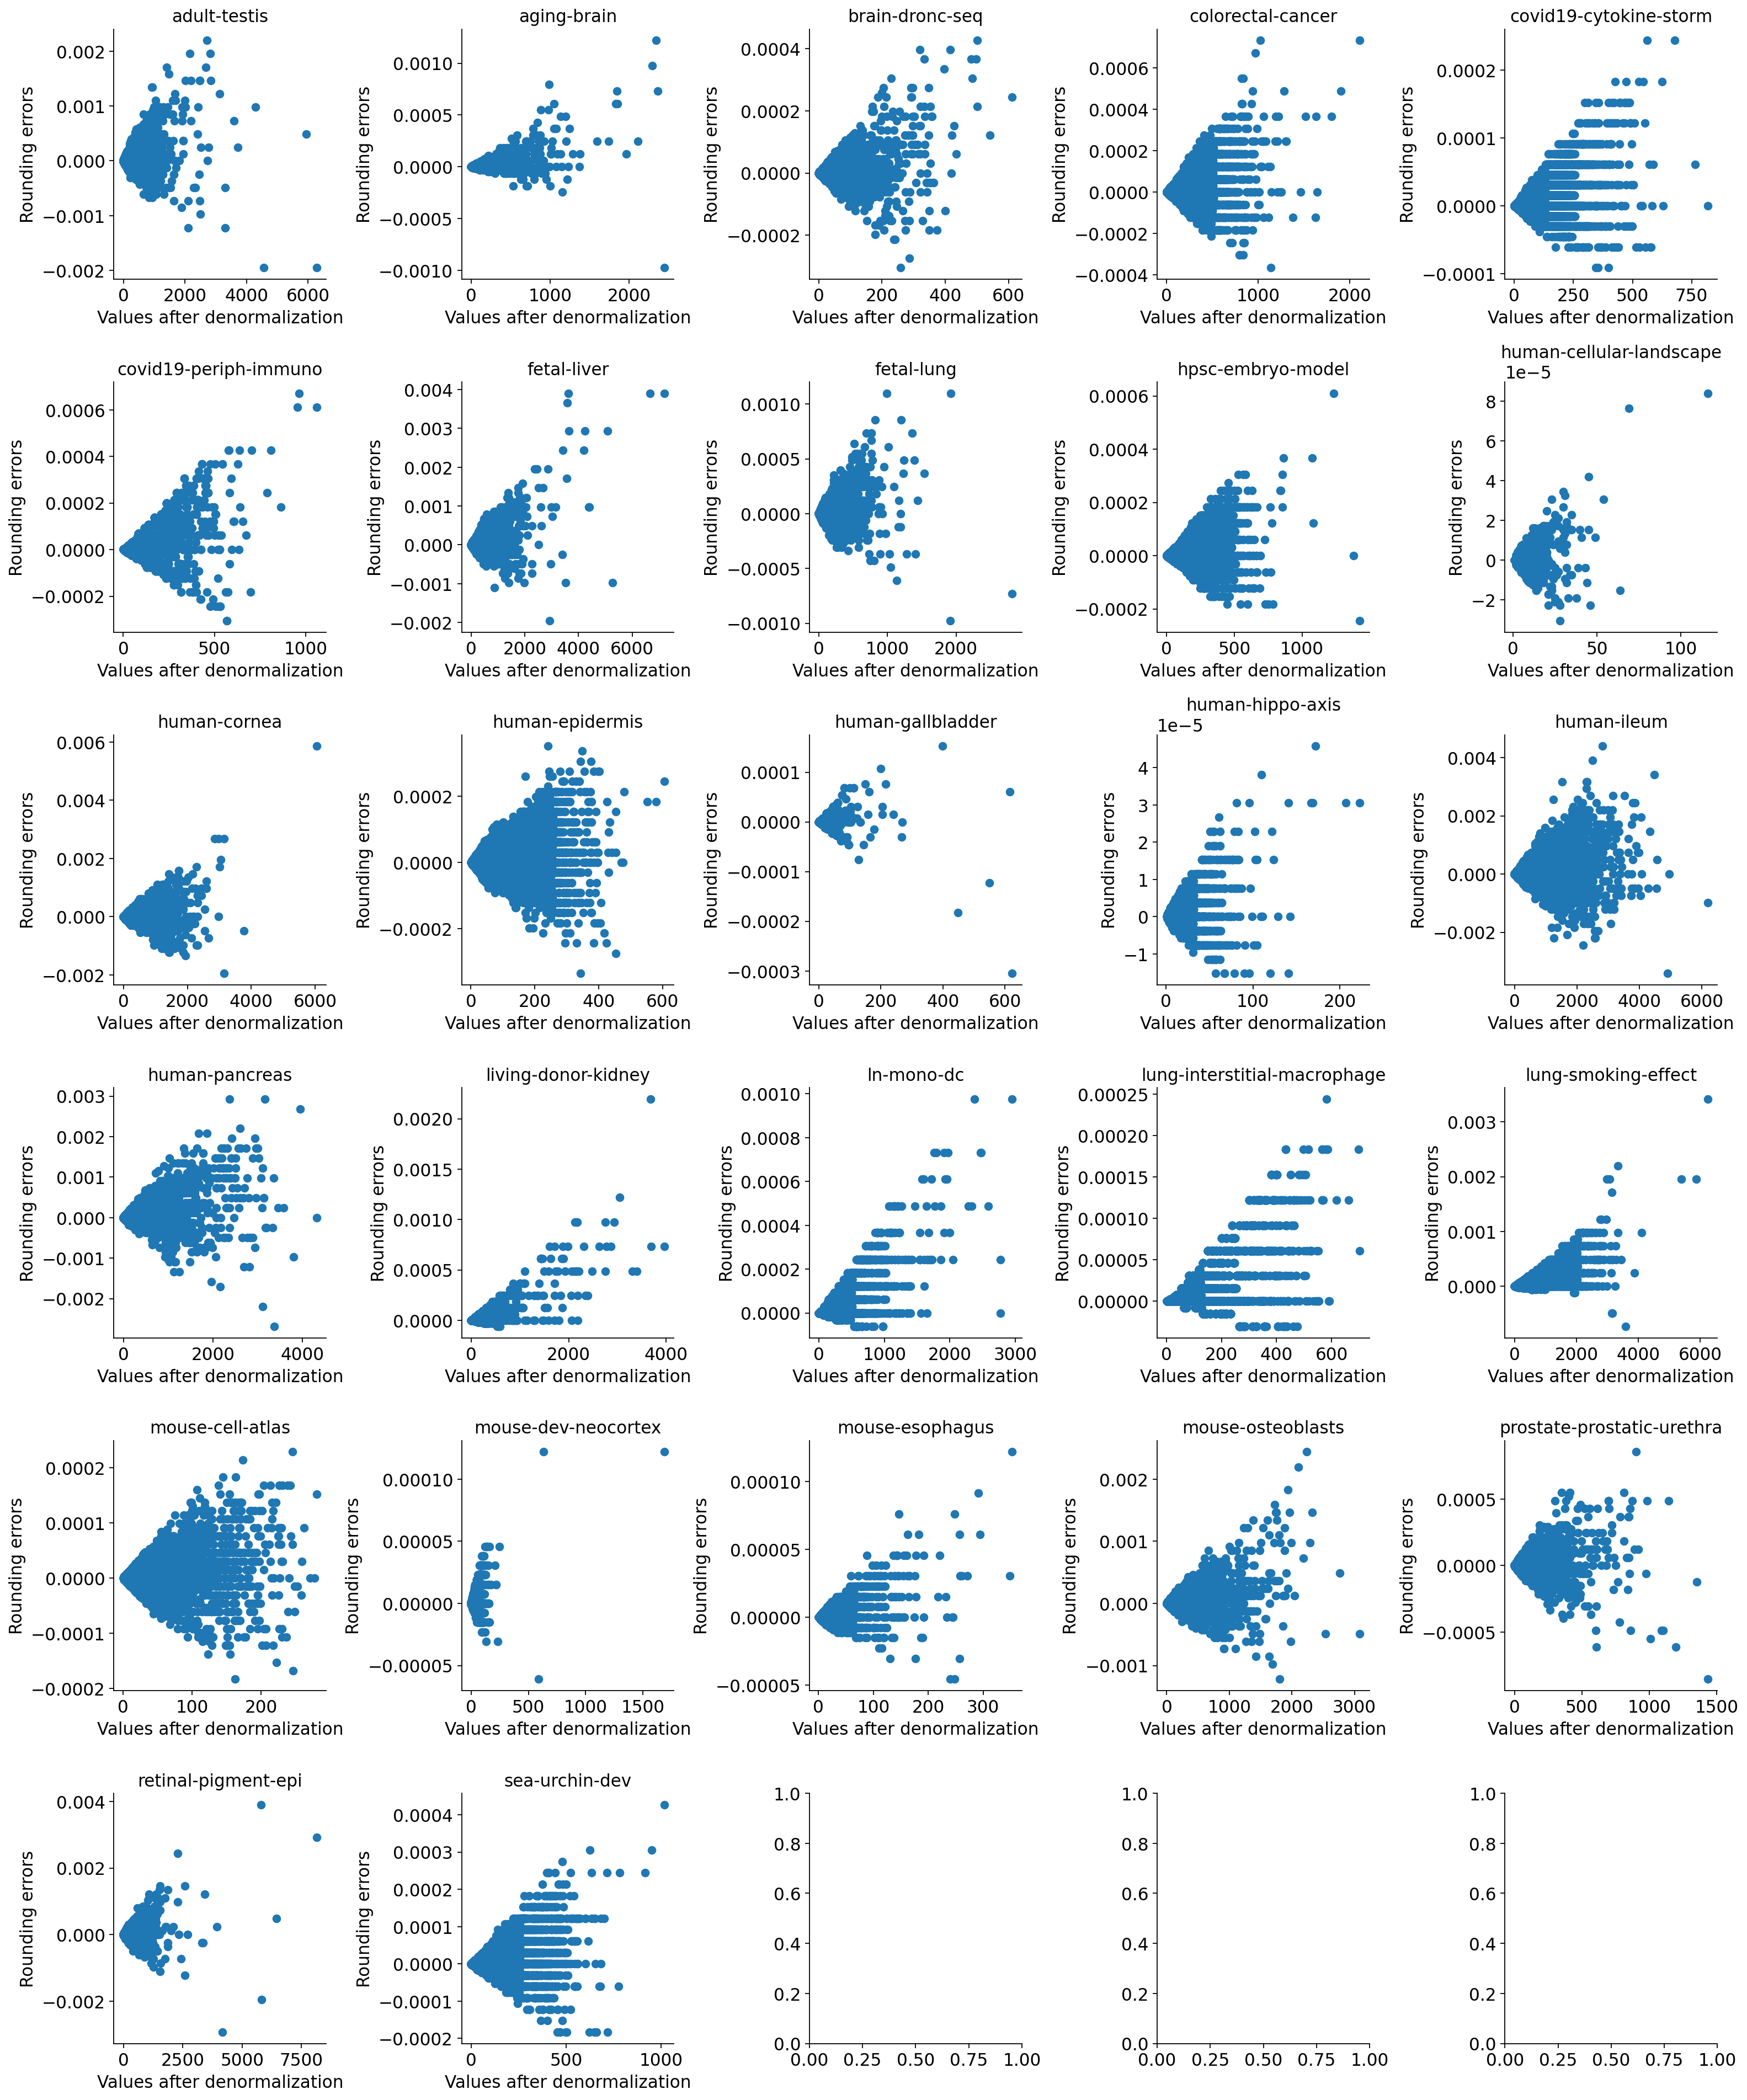

In [21]:
# Create a 5x4 subplot grid
fig, axs = plt.subplots(6, 5, figsize=(20, 24))

# Loop through each subplot and plot the data
for i in range(6):
    for j in range(5):
        try:
            ax = axs[i, j]
            ax.plot(ads_dn[i*5+j].data, rounding_ers[i*5+j].data, 'o')
            ax.grid(visible=False)
            ax.set_xlabel('Values after denormalization')
            ax.set_ylabel('Rounding errors')
            ax.set_title(h5_names[i*5+j])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        except:
            pass

# Adjust the spacing between subplots
plt.tight_layout()

plt.savefig('SF4_recon_errors.png',dpi=300, bbox_inches='tight',transparent=True)

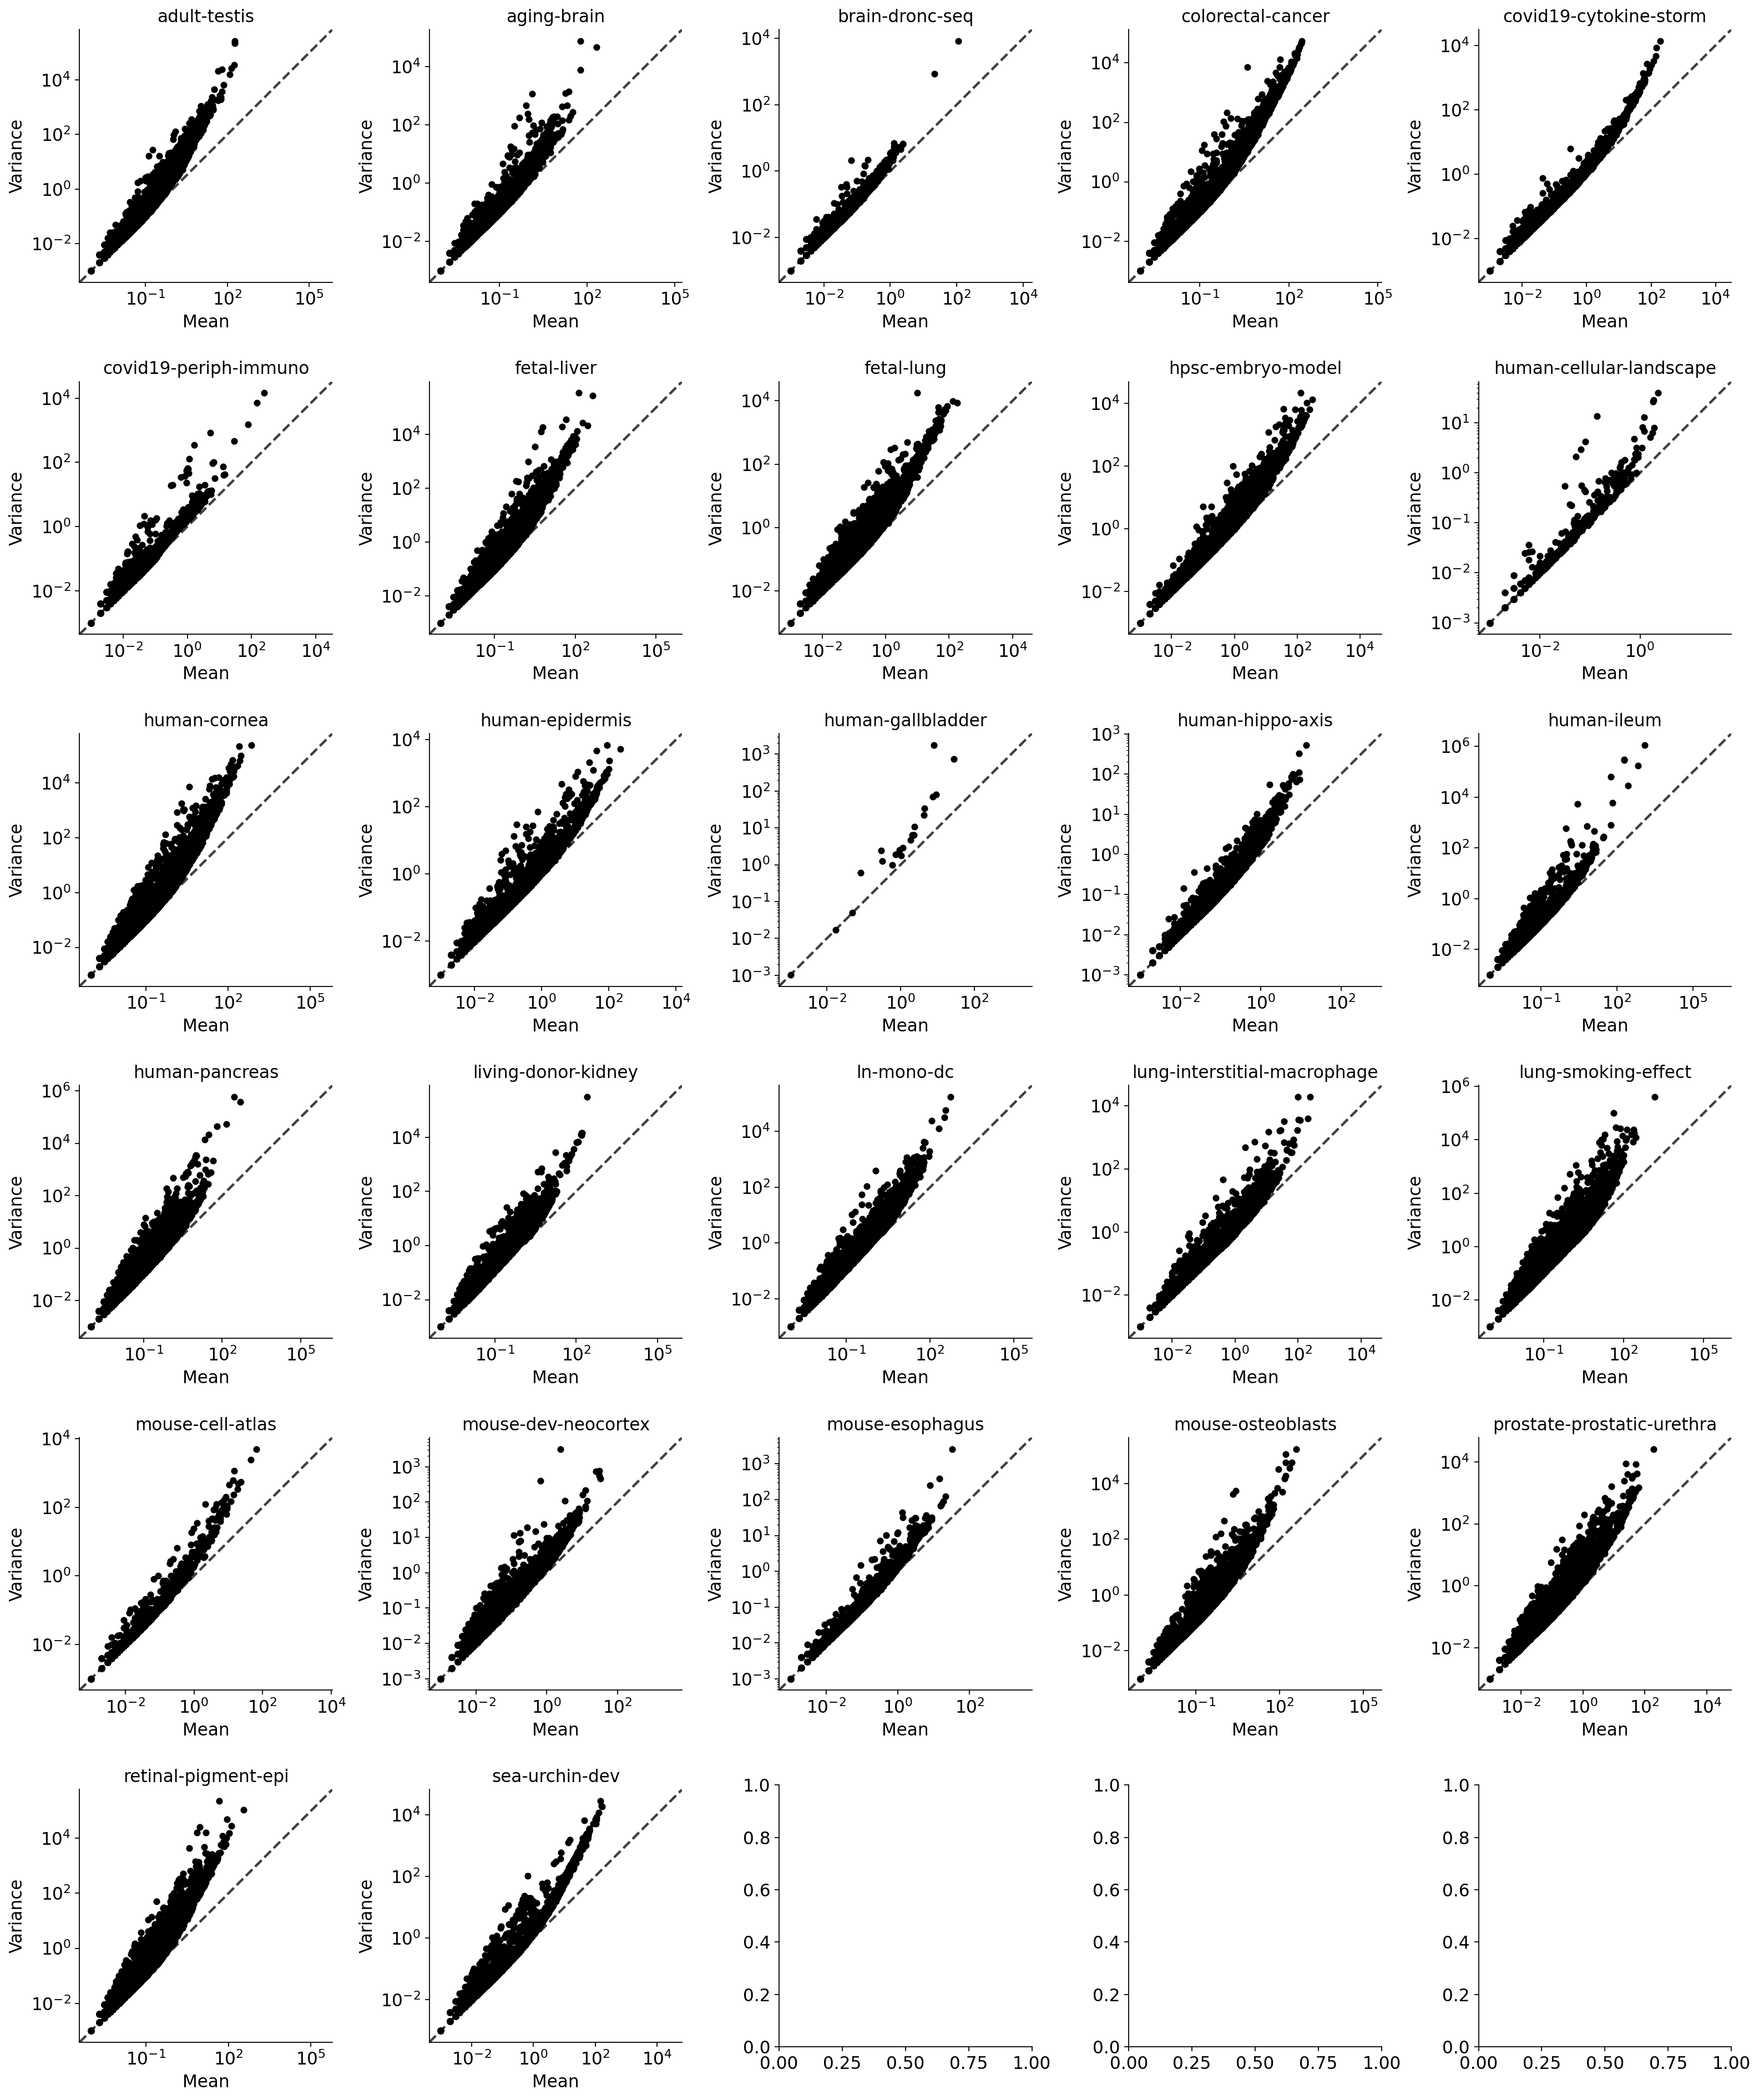

In [20]:
# Create a 5x4 subplot grid
fig, axs = plt.subplots(6, 5, figsize=(20, 24))

# Loop through each subplot and plot the data
for i in range(6):
    for j in range(5):
        try:
            ax = axs[i, j]
            smtx=ads_dn[i*5+j]
            cmean = np.array(smtx.mean(0))
            cvar = np.array(smtx.power(2).mean(0) - cmean ** 2)
            plot_mv(cmean,cvar,ax,title=h5_names[i*5+j],c='black',fit=False)
        except:
            pass

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.savefig('SF5.png',dpi=300, bbox_inches='tight',transparent=True)